In [1]:
import json

# Path to your annotation file
train_rle_json = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/instances_train_city_vps_rle.json'

with open(train_rle_json, 'r') as f:
    train_data = json.load(f)

images = train_data['images']
annotations = train_data['annotations']
categories = train_data['categories']

print(f"Number of images: {len(images)}")
print(f"Number of annotations: {len(annotations)}")
print(f"Number of categories: {len(categories)}")


Number of images: 2400
Number of annotations: 44432
Number of categories: 8


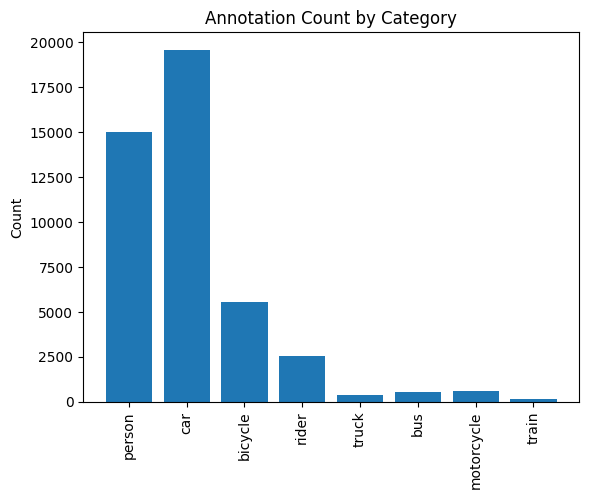

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

cat_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Count annotations by category_id
cat_counts = Counter([ann['category_id'] for ann in annotations])

# Plot
cats = []
counts = []
for cat_id, count in cat_counts.items():
    cats.append(cat_id_to_name[cat_id])
    counts.append(count)

plt.bar(cats, counts)
plt.xticks(rotation=90)
plt.title("Annotation Count by Category")
plt.ylabel("Count")
plt.show()


In [11]:
# import json
# import pycocotools.mask as mask_utils
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the dataset
# file_path = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/instances_train_city_vps_rle.json'
# with open(file_path, 'r') as f:
#     data = json.load(f)

# annotations = data['annotations']

# areas = []

# for ann in annotations:
#     segm = ann['segmentation']
    
#     # Check if segmentation is RLE or uncompressed
#     if isinstance(segm, dict):
#         # Handle compressed RLE
#         if isinstance(segm['counts'], list):
#             # Convert uncompressed RLE to compressed
#             rle = mask_utils.frPyObjects([segm], segm['size'][0], segm['size'][1])
#             rle = mask_utils.merge(rle)
#         else:
#             rle = segm
#     else:
#         # If segmentation is not RLE, handle polygon or other formats (not implemented here)
#         continue
    
#     # Decode RLE to binary mask
#     mask = mask_utils.decode(rle)
#     # Calculate area
#     area = np.sum(mask)
#     areas.append(area)

# # Plot histogram of areas
# plt.hist(areas, bins=50, log=True)
# plt.title("Distribution of Instance Areas")
# plt.xlabel("Area (in pixels)")
# plt.ylabel("Frequency (log scale)")
# plt.show()

In [22]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_utils
import json
import os

# Load the dataset
file_path = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/instances_train_city_vps_rle.json'
image_folder = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/train/inst/'

with open(file_path, 'r') as f:
    data = json.load(f)

images = data['images']
annotations = data['annotations']

# Helper function to decode masks and overlay them on images
def plot_sample(image_path, annotations_for_image):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return  # Skip this sample

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return  # Skip this sample

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    overlay = image.copy()
    for ann in annotations_for_image:
        segm = ann['segmentation']
        if isinstance(segm, dict):
            if isinstance(segm['counts'], list):
                rle = mask_utils.frPyObjects([segm], segm['size'][0], segm['size'][1])
                rle = mask_utils.merge(rle)
            else:
                rle = segm
        else:
            continue
        
        mask = mask_utils.decode(rle)
        color = tuple(np.random.randint(0, 256, size=3, dtype=int))  # Random color
        overlay[mask == 1] = color

    # Combine overlay and original image
    combined = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()

# Function to validate the image path
def validate_path(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return False
    return True

# Randomly select a few samples to visualize
num_samples = 3
sampled_images = random.sample(images, num_samples)

# Adjusted image path construction and visualization
for img_info in sampled_images:
    img_id = img_info['id']
    img_file = img_info['file_name']
    
    # Attempt adjustments if necessary
    possible_files = [
        img_file,
        img_file.replace('newImg8bit', 'leftImg8bit'),
        img_file.replace('leftImg8bit', 'newImg8bit')
    ]
    
    # Check if any adjusted file exists
    img_path = None
    for file in possible_files:
        potential_path = f"{image_folder.rstrip('/')}/{file}"
        if os.path.exists(potential_path):
            img_path = potential_path
            break

    if not img_path:
        print(f"Image not found for all variations: {img_file}")
        continue

    print(f"Loading image from: {img_path}")
    ann_for_image = [ann for ann in annotations if ann['image_id'] == img_id]
    plot_sample(img_path, ann_for_image)


Image not found for all variations: 0053_0316_frankfurt_000001_002512_leftImg8bit.png
Image not found for all variations: 0007_0042_frankfurt_000000_002973_newImg8bit.png
Image not found for all variations: 0416_2495_munster_000089_000024_newImg8bit.png


In [23]:
import difflib

def find_closest_match(json_filename, actual_files):
    # Use difflib to find the closest match
    matches = difflib.get_close_matches(json_filename, actual_files, n=1, cutoff=0.8)
    if matches:
        return matches[0]
    return None

# Dynamically adjust paths for unmatched files
for img_info in sampled_images:
    img_id = img_info['id']
    json_filename = img_info['file_name']
    
    # Try to find the closest match
    closest_match = find_closest_match(json_filename, actual_files)
    
    if closest_match:
        img_path = f"{image_folder}/{closest_match}"
        print(f"Matched {json_filename} to {closest_match}")
    else:
        print(f"No match found for: {json_filename}")
        continue
    
    # Get annotations for this image
    ann_for_image = [ann for ann in annotations if ann['image_id'] == img_id]
    plot_sample(img_path, ann_for_image)


No match found for: 0053_0316_frankfurt_000001_002512_leftImg8bit.png
No match found for: 0007_0042_frankfurt_000000_002973_newImg8bit.png
No match found for: 0416_2495_munster_000089_000024_newImg8bit.png


In [25]:
import difflib

# Helper function to find the closest match in the actual file directory
def find_closest_match(json_filename, actual_files):
    # Use difflib to find the closest match
    matches = difflib.get_close_matches(json_filename, actual_files, n=1, cutoff=0.8)
    if matches:
        return matches[0]
    return None

# Dynamically adjust paths for unmatched files
for img_info in sampled_images:
    img_id = img_info['id']
    json_filename = img_info['file_name']
    
    # Try to find the closest match
    closest_match = find_closest_match(json_filename, actual_files)
    
    if closest_match:
        img_path = f"{image_folder}/{closest_match}"
        print(f"Matched JSON file {json_filename} to directory file {closest_match}")
    else:
        print(f"No match found for: {json_filename}")
        continue
    
    # Get annotations for this image
    ann_for_image = [ann for ann in annotations if ann['image_id'] == img_id]
    plot_sample(img_path, ann_for_image)


No match found for: 0053_0316_frankfurt_000001_002512_leftImg8bit.png
No match found for: 0007_0042_frankfurt_000000_002973_newImg8bit.png
No match found for: 0416_2495_munster_000089_000024_newImg8bit.png


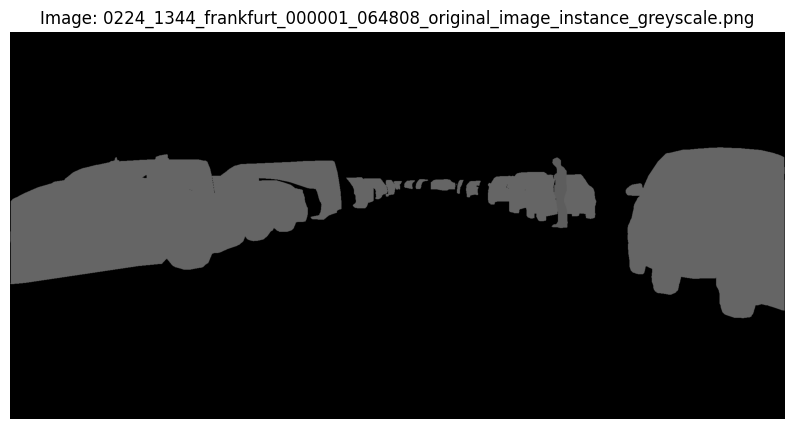

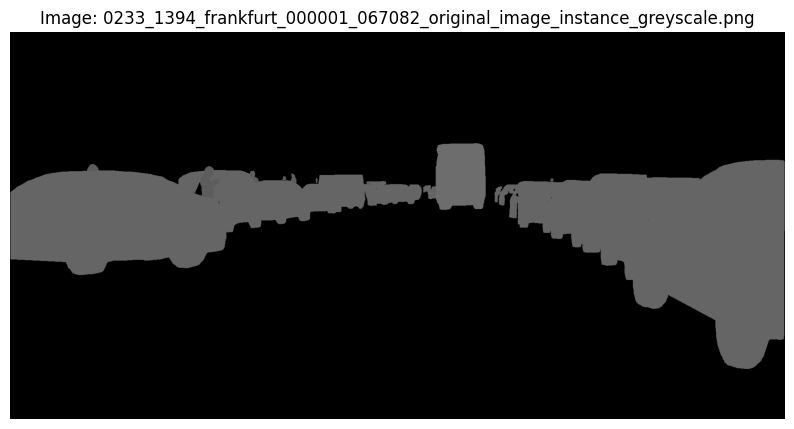

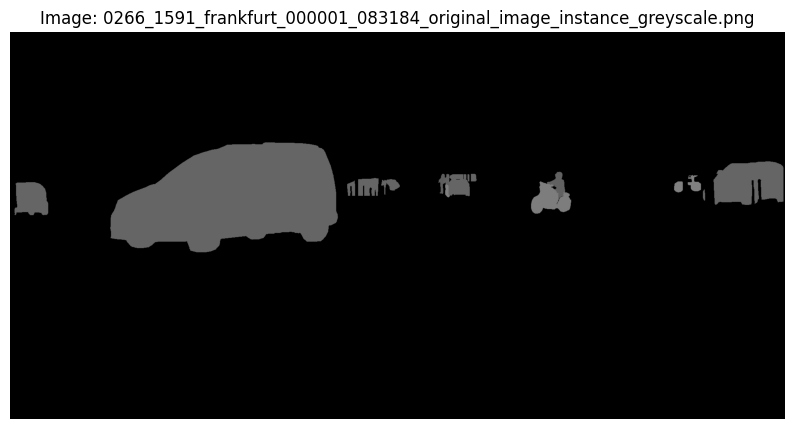

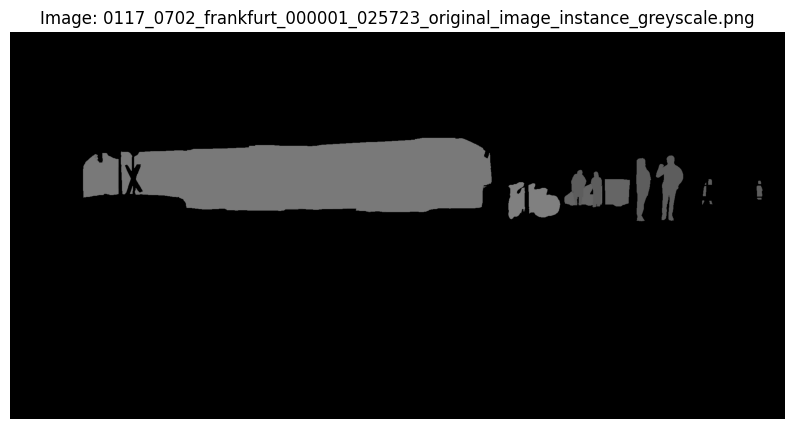

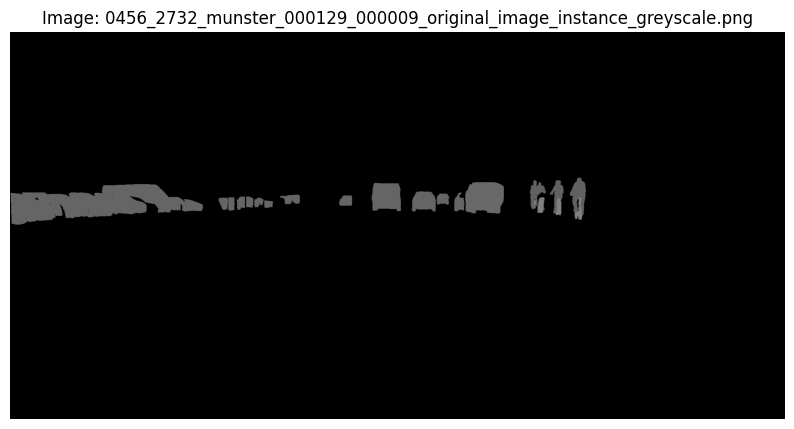

In [26]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the image folder path
image_folder = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/train/inst/'

# List all images in the directory
actual_files = os.listdir(image_folder)

# Randomly select 5 images
selected_files = random.sample(actual_files, 5)

# Plot the images
for img_file in selected_files:
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path)

    if image is None:
        print(f"Failed to load image: {img_path}")
        continue
    
    # Convert BGR to RGB for displaying
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"Image: {img_file}")
    plt.axis('off')
    plt.show()


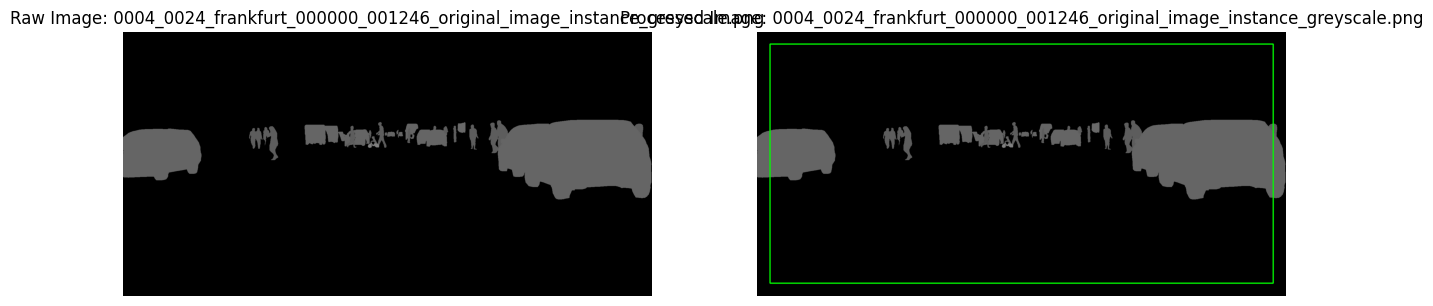

In [31]:
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Define the image folder path
image_folder = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/train/inst/'

# List all images in the directory
actual_files = sorted(os.listdir(image_folder))  # Sort to maintain sequence order

# Select a subset (e.g., first 20 images for demonstration)
selected_files = actual_files[:20]  # Adjust the range as needed

# Play the images as a sequence
for img_file in selected_files:
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path)

    if image is None:
        print(f"Failed to load image: {img_path}")
        continue

    # Convert BGR to RGB for raw display
    raw_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a processed version for demonstration
    # Add a simulated annotation (e.g., rectangle) on the processed image
    processed_image = image.copy()
    height, width, _ = processed_image.shape
    cv2.rectangle(processed_image, (50, 50), (width - 50, height - 50), (0, 255, 0), 3)
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

    # Display the raw and processed images side by side
    clear_output(wait=True)
    plt.figure(figsize=(15, 6))

    # Raw footage
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image)
    plt.title(f"Raw Image: {img_file}")
    plt.axis('off')

    # Processed image
    plt.subplot(1, 2, 2)
    plt.imshow(processed_image)
    plt.title(f"Processed Image: {img_file}")
    plt.axis('off')

    plt.show()

    # Add a delay to simulate a video sequence
    time.sleep(0.2)  # Adjust delay (in seconds) for faster or slower playback


In [37]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pycocotools.mask as mask_utils

# Paths to JSON files and images
annotations_file = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/instances_train_city_vps_rle.json'
image_folder = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/train/inst/'  # Update this path if needed

# Load the annotations
with open(annotations_file, 'r') as f:
    annotations_data = json.load(f)

annotations = annotations_data['annotations']
images = annotations_data['images']
categories = annotations_data['categories']

# Map image_id to file_name
image_map = {img['id']: img['file_name'] for img in images}

# Map category_id to category name
category_map = {cat['id']: cat['name'] for cat in categories}

# Function to decode and overlay masks on raw images
def plot_instance_masks(image_id, annotations, image_folder, image_map):
    # Get the file name for the image
    if image_id not in image_map:
        print(f"No image found for ID {image_id}")
        return
    
    img_file = image_map[image_id]
    img_path = os.path.join(image_folder, img_file)

    # Load the raw image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image not found at {img_path}")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Overlay masks on the image
    overlay = image.copy()
    for ann in annotations:
        if ann['image_id'] == image_id:
            segm = ann['segmentation']
            
            # Decode RLE masks
            if isinstance(segm, dict):
                mask = mask_utils.decode(segm)
            else:
                continue
            
            # Generate a random color for the mask
            color = np.random.randint(0, 255, size=3, dtype=np.uint8)
            overlay[mask == 1] = overlay[mask == 1] * 0.5 + color * 0.5
    
    # Display the image with masks
    plt.figure(figsize=(12, 8))
    plt.imshow(overlay)
    plt.title(f"Instance Masks for Image ID: {image_id}")
    plt.axis('off')
    plt.show()

# Example: Plot instance masks for the first image in the dataset
example_image_id = images[0]['id']  # Use the first image ID as an example
plot_instance_masks(example_image_id, annotations, image_folder, image_map)


Image not found at /Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/train/inst/0001_0001_frankfurt_000000_000279_newImg8bit.png


[ WARN:0@4295.918] global loadsave.cpp:241 findDecoder imread_('/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/train/inst/0001_0001_frankfurt_000000_000279_newImg8bit.png'): can't open/read file: check file path/integrity


In [1]:
import os
import json
import numpy as np
import cv2
import pycocotools.mask as mask_utils
import shutil

# Paths to raw images and JSON annotations
raw_images_dir = '/Users/srirammandalika/Downloads/Cityscapes Image Pairs/cityscapes_split/train_left'
annotations_file = '/Users/srirammandalika/Downloads/cityscapes-vps-dataset-1.0/instances_train_city_vps_rle.json'

# Output directories for raw images and instance masks
output_base_dir = '/Users/srirammandalika/Downloads/mapped_data/'
raw_images_output = os.path.join(output_base_dir, 'raw_images/')
instance_masks_output = os.path.join(output_base_dir, 'instance_masks/')

# Create output directories if they don't exist
os.makedirs(raw_images_output, exist_ok=True)
os.makedirs(instance_masks_output, exist_ok=True)

# Load the annotations
with open(annotations_file, 'r') as f:
    annotations_data = json.load(f)

images = annotations_data['images']
annotations = annotations_data['annotations']

# Map image_id to file_name
image_map = {img['id']: img['file_name'] for img in images}

# Map raw images (sequentially named) to their corresponding JSON file names
raw_image_files = sorted(os.listdir(raw_images_dir))[:len(images)]  # Match the count to JSON entries

# Map and process raw images and instance masks
for raw_file, image_entry in zip(raw_image_files, images):
    # Get the proper name from JSON
    proper_name = image_entry['file_name']  # e.g., 'frankfurt_000000_000294_leftImg8bit.png'
    image_id = image_entry['id']

    # Define source and destination paths for raw images
    src_path = os.path.join(raw_images_dir, raw_file)
    dest_path_raw = os.path.join(raw_images_output, proper_name)

    # Copy and rename the raw image
    shutil.copy(src_path, dest_path_raw)

    # Create and save the instance mask
    mask = np.zeros((image_entry['height'], image_entry['width']), dtype=np.uint8)
    for ann in annotations:
        if ann['image_id'] == image_id:
            segm = ann['segmentation']

            # Decode RLE masks, handle uncompressed RLE
            if isinstance(segm, dict) and isinstance(segm['counts'], list):
                rle = mask_utils.frPyObjects(segm, segm['size'][0], segm['size'][1])
                decoded_mask = mask_utils.decode(rle)
            elif isinstance(segm, dict):
                decoded_mask = mask_utils.decode(segm)
            else:
                continue
            
            # Assign category ID to mask
            mask = np.maximum(mask, decoded_mask * ann['category_id'])

    # Save the instance mask
    dest_path_mask = os.path.join(instance_masks_output, proper_name.replace('_leftImg8bit.png', '_mask.png'))
    cv2.imwrite(dest_path_mask, mask)
    print(f"Processed raw image and mask: {proper_name}")

print(f"All raw images and instance masks have been saved in {output_base_dir}")


Processed raw image and mask: 0001_0001_frankfurt_000000_000279_newImg8bit.png
Processed raw image and mask: 0001_0002_frankfurt_000000_000284_newImg8bit.png
Processed raw image and mask: 0001_0003_frankfurt_000000_000289_newImg8bit.png
Processed raw image and mask: 0001_0004_frankfurt_000000_000294_leftImg8bit.png
Processed raw image and mask: 0001_0005_frankfurt_000000_000299_newImg8bit.png
Processed raw image and mask: 0001_0006_frankfurt_000000_000304_newImg8bit.png
Processed raw image and mask: 0002_0007_frankfurt_000000_000561_newImg8bit.png
Processed raw image and mask: 0002_0008_frankfurt_000000_000566_newImg8bit.png
Processed raw image and mask: 0002_0009_frankfurt_000000_000571_newImg8bit.png
Processed raw image and mask: 0002_0010_frankfurt_000000_000576_leftImg8bit.png
Processed raw image and mask: 0002_0011_frankfurt_000000_000581_newImg8bit.png
Processed raw image and mask: 0002_0012_frankfurt_000000_000586_newImg8bit.png
Processed raw image and mask: 0003_0013_frankfurt_

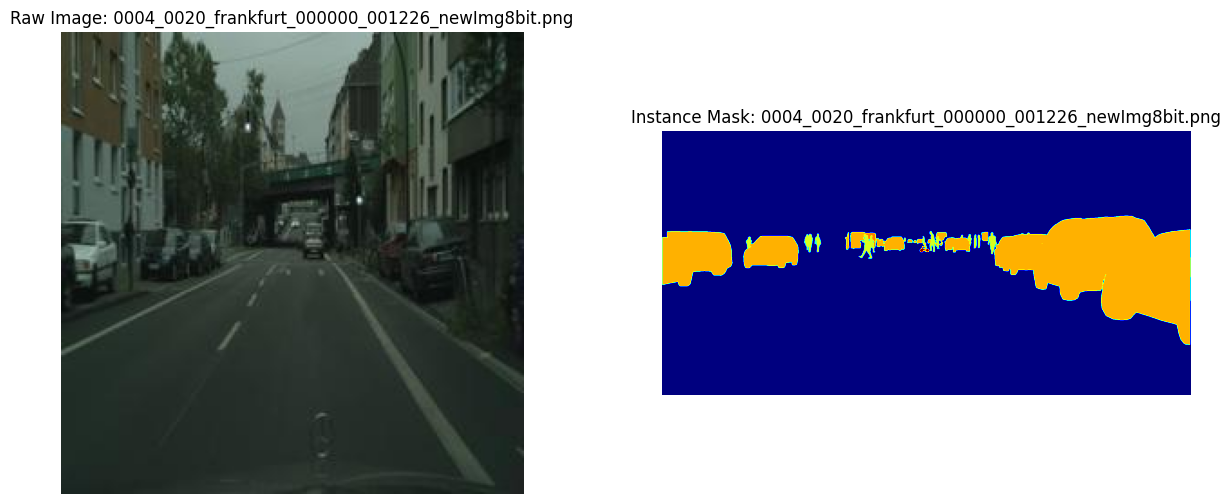

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Define the directories for raw images and instance masks
base_dir = '/Users/srirammandalika/Downloads/mapped_data/'
raw_images_dir = os.path.join(base_dir, 'raw_images/')
instance_masks_dir = os.path.join(base_dir, 'instance_masks/')

# Get sorted lists of raw images and instance masks
raw_image_files = sorted(os.listdir(raw_images_dir))
instance_mask_files = sorted(os.listdir(instance_masks_dir))

# Ensure both directories have the same number of files
if len(raw_image_files) != len(instance_mask_files):
    print("Mismatch in number of raw images and instance masks.")
    exit()

# Select the first 20 samples for demonstration
raw_image_files = raw_image_files[:20]
instance_mask_files = instance_mask_files[:20]

# Plot the sequence
for raw_file, mask_file in zip(raw_image_files, instance_mask_files):
    # Load the raw image
    raw_image_path = os.path.join(raw_images_dir, raw_file)
    raw_image = cv2.imread(raw_image_path)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    # Load the instance mask
    mask_path = os.path.join(instance_masks_dir, mask_file)
    instance_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

    # Display the raw image and instance mask side-by-side
    clear_output(wait=True)
    plt.figure(figsize=(15, 6))

    # Plot raw image
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image)
    plt.title(f"Raw Image: {raw_file}")
    plt.axis('off')

    # Plot instance mask
    plt.subplot(1, 2, 2)
    plt.imshow(instance_mask, cmap='jet')  # Use 'jet' colormap for better visualization
    plt.title(f"Instance Mask: {mask_file}")
    plt.axis('off')

    plt.show()

    # Delay to simulate video playback
    time.sleep(0.5)  # Adjust delay as needed
